In [1]:
#!/usr/bin/env python
# coding: utf-8

Test Machine Learning algorithms

In [2]:
# Import librairies
import os
import re

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import shutil
import sys
import warnings

from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import hamming_loss, confusion_matrix, multilabel_confusion_matrix, classification_report
from sklearn.metrics import coverage_error, label_ranking_average_precision_score, label_ranking_loss
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder
from sklearn.svm import LinearSVC, SVC

from skmultilearn.adapt import MLkNN
from skmultilearn.model_selection import iterative_train_test_split
from skmultilearn.model_selection.measures import get_combination_wise_output_matrix
from skmultilearn.problem_transform import ClassifierChain, BinaryRelevance, LabelPowerset

from scipy.sparse import csr_matrix, lil_matrix
from yellowbrick.text import FreqDistVisualizer, TSNEVisualizer



In [3]:
# Suppression des FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.filterwarnings("ignore")

In [9]:
# Activation PEP8
%load_ext pycodestyle_magic
%pycodestyle_on

In [ ]:
# Parametres graphiques
%matplotlib inline
rc = {
    'font.size': 14,
    'font.family': 'Arial',
    'axes.labelsize': 14,
    'legend.fontsize': 12,
    'axes.titlesize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'figure.max_open_warning': 30}

sns.set(font='Arial', rc=rc)
sns.set_style(
    "whitegrid", {
        'axes.edgecolor': 'k',
        'axes.linewidth': 1,
        'axes.grid': True,
        'xtick.major.width': 1,
        'ytick.major.width': 1
        })
sns.set_context(
    "notebook",
    font_scale=1.1,
    rc={"lines.linewidth": 1.5})
pd.set_option('display.max_columns', None)

In [12]:
# Define path
data_path = "./data"

In [13]:
# Import data
df = pd.read_csv(os.path.join(data_path, "working_data_rameau_preprocessed_datav1.csv"), converters={"rameau_list_unstack": eval}, index_col=0)
print(df.shape)
df.head()

(89416, 12)


,PPN,TITRE,RESUME,RAMEAU,DEWEY,DESCR,DDC,TEF_LABEL,test_tiret,rameau_list,rameau_list_unstack,DESCR_processed
0,000002364,La culture pour vivre,Mort de la culture populaire en France. Mutati...,Culture populaire;Diffusion de la culture;Poli...,840,La culture pour vivre Mort de la culture popul...,840.0,Littérature de langues romanes. Littérature fr...,False,['Culture populaire;Diffusion de la culture;Po...,"[Culture populaire, Diffusion de la culture, P...",culture vivre mort culture populaire franc mut...
1,000014877,"La nuit, le jour : essai psychanalytique sur l...","Discontinuité, latence, rétablissement dune c...",Complexe de castration;Psychanalyse;Rêves,154.63,"La nuit, le jour : essai psychanalytique sur l...",150.0,Psychologie,False,['Complexe de castration;Psychanalyse;Rêves'],"[Complexe de castration, Psychanalyse, Rêves]",nuit jour essai psychanalytique fonctionnement...
2,000021857,"Ruptures, cultures","Il faut imaginer Robinson sur son île, au mome...",Culture,840,"Ruptures, cultures Il faut imaginer Robinson s...",840.0,Littérature de langues romanes. Littérature fr...,False,['Culture'],[Culture],rupture culture falloir imaginer robinson il m...
3,00002564X,La révolution structurale,"Mutations ou crises, les brusques accès de fiè...",Structuralisme,100,"La révolution structurale Mutations ou crises,...",100.0,"Philosophie, psychologie",False,['Structuralisme'],[Structuralisme],revolution structural mutation crise brusque a...
4,000026352,La Destruction du temple,"Oswald tire sur Kennedy. Jusque-là, c'est bon,...",Science-fiction américaine -- Traductions fran...,830,La Destruction du temple Oswald tire sur Kenne...,830.0,Littérature allemande,True,['Science-fiction américaine -- Traductions fr...,"[Science-fiction américaine, Traductions franç...",destruction temple oswald tire kennedy bon foi...


2:80: E501 line too long (143 > 79 characters)


In [14]:
# label encoding
def encoding(df, corpus, col_label):
    df_encoded = df.copy()

    # define X and y
    X = df_encoded[corpus]
    y = df_encoded[col_label]

    # encode labels
    mlb = MultiLabelBinarizer()
    y_encoded = mlb.fit_transform(y)
    classes = mlb.classes_
    return X, y_encoded, classes, mlb

## Split dataset

In [16]:
# Iterative Splitting pour multilabel
def iterative_train_test_split_dataframe(df, corpus, col_label, test_size):

    # encode labels
    print("Encoding labels")
    X, y, classes, mlb = encoding(
        df,
        corpus=corpus,
        col_label=col_label)
    print("Labels encoded")

    # split data
    print("splitting data")
    df_index = X.index.to_numpy().reshape(-1, 1)
    df_index_train, y_train, df_index_test, y_test = iterative_train_test_split(
        df_index, y, test_size=test_size)
    print("Data splitted")
    print("Finalizing X_train and X_test")
    X_train = X.loc[df_index_train[:, 0]]
    X_test = X.loc[df_index_test[:, 0]]
    return (
        X_train, y_train,
        X_test, y_test,
        df_index_train, df_index_test,
        classes, mlb)

15:80: E501 line too long (80 > 79 characters)


In [17]:
# Split data
X_train, y_train, X_test, y_test, index_train, index_test, classes, mlb = iterative_train_test_split_dataframe(
    df,
    corpus="DESCR_processed",
    col_label="rameau_list_unstack",
    test_size=0.25)

Encoding labels
Labels encoded
splitting data
Data splitted
Finalizing X_train and X_test


2:80: E501 line too long (111 > 79 characters)


In [18]:
# Check classes
print("nombre de labels différents: ", len(classes))
classes

nombre de labels différents:  21374


array(["'Ndrangheta",
       '10 et 11 janvier 2015, Manifestations des (France)',
       '11 septembre 2001, Attentats du (États-Unis)', ...,
       'Îlot thermique urbain', 'économie', 'éthique'], dtype=object)

In [19]:
# Check size of test and train datasets
print(f"train dataset size : {len(y_train)}")
print(f"test dataset size : {len(y_test)}")

train dataset size : 67038
test dataset size : 22378


In [20]:
# Check splitting balance
from skmultilearn.model_selection.measures import get_combination_wise_output_matrix
order = 3
X, y, classes, _ = encoding(
    df,
    corpus="DESCR_processed",
    col_label="rameau_list_unstack")
Counter(combination for row in get_combination_wise_output_matrix(y, order=order) for combination in row)

NameError: name 'Counter' is not defined

2:80: E501 line too long (84 > 79 characters)
8:80: E501 line too long (105 > 79 characters)


In [ ]:
# Balance following data split
pd.DataFrame({
    'train': Counter(
        str(combination) for row in get_combination_wise_output_matrix(
            y_train, order=order) for combination in row),
    'test': Counter(
        str(combination) for row in get_combination_wise_output_matrix(
            y_test, order=order) for combination in row)
}).T.fillna(0.0)

## Vectorize dataset (tf-idf)

In [21]:
# TF-IDf vectorization
def vectorizer_tfidf(
    X_train, X_test, max_df, min_df,
    max_features, n_gram=(1, 2),
    save=True):
    regex_pattern = r'\w{3,}'
    vectorizer = TfidfVectorizer(
        max_df=max_df,
        min_df=min_df,
        max_features=max_features,
        ngram_range=n_gram,
        token_pattern=regex_pattern)
    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)
    features = vectorizer.get_feature_names_out()
    if save:
        pickle.dump(
            vectorizer,
            open(os.path.join(output_path, "tfidf.pickle"), "wb"))
    return X_train, X_test, features

5:5: E125 continuation line with same indent as next logical line


In [22]:
# Set parameters for tf-idf
max_df = 0.5
min_df = 5
max_features = 500
n_gram = (1, 3)

In [23]:
# Vectorize corpus
X_train_vect, X_test_vect, features = vectorizer_tfidf(
    X_train, X_test, max_df, min_df,
    max_features, n_gram=n_gram, save=False)

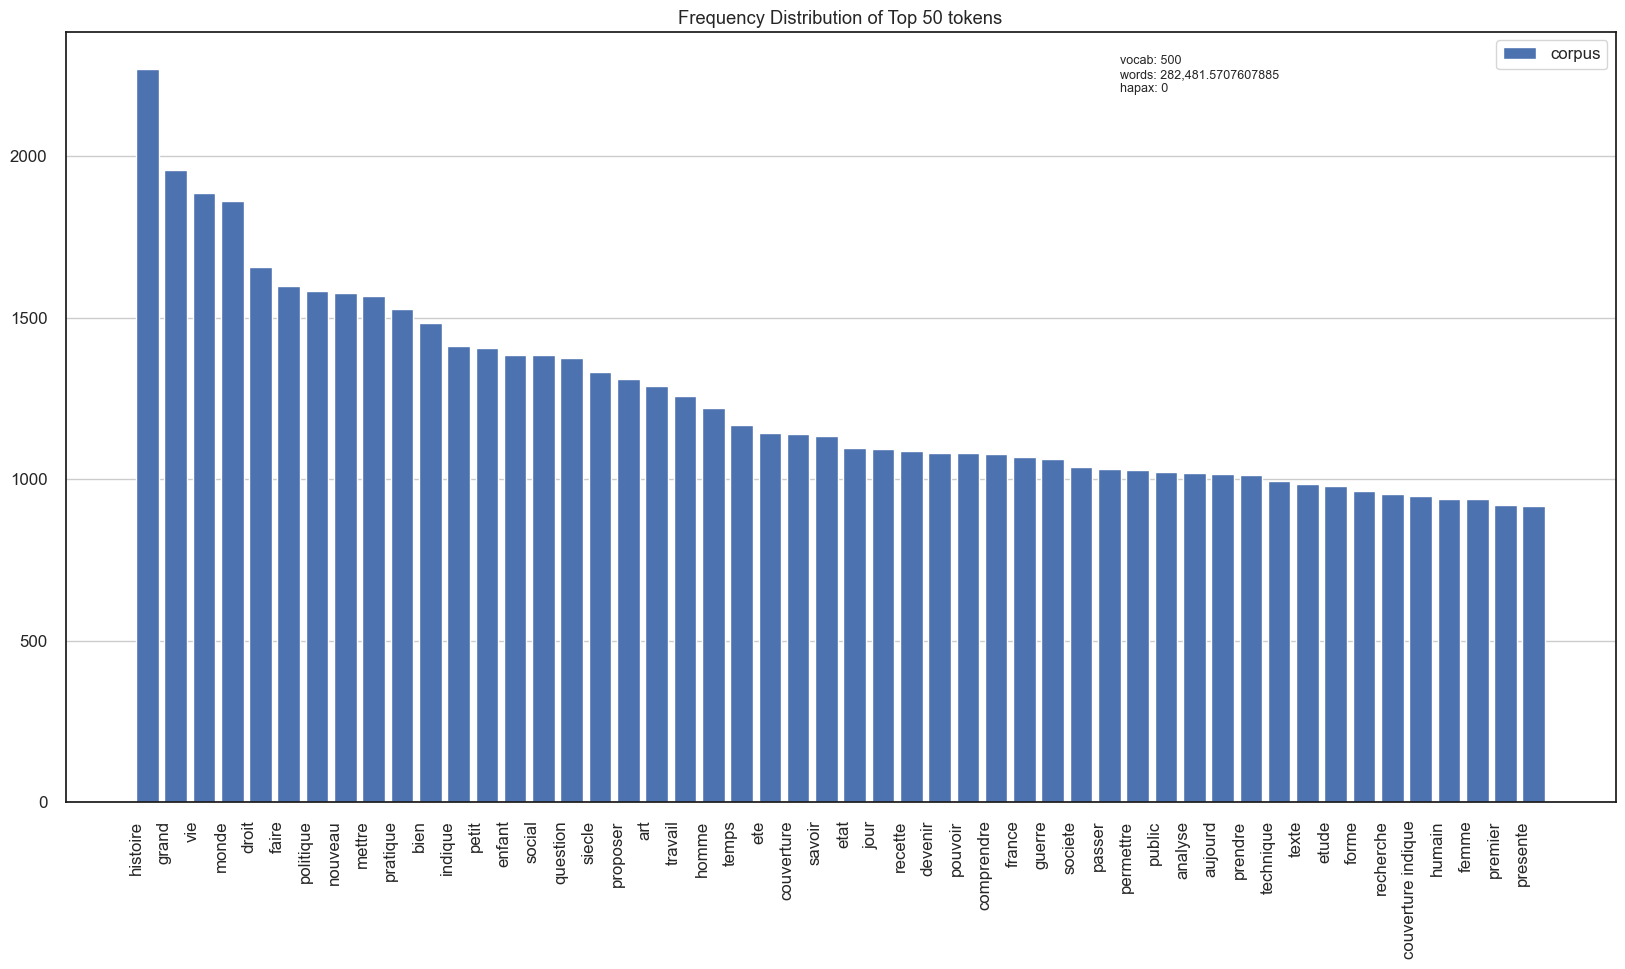

<Axes: title={'center': 'Frequency Distribution of Top 50 tokens'}>

In [24]:
# Visualize Word Frequency Distribution
plt.figure(figsize=(20, 10))
visualizer = FreqDistVisualizer(features=features, n=50, orient="v")
visualizer.fit(X_train_vect)
visualizer.show()

In [25]:
# Encoding TEF labels
lab_encod = LabelEncoder()
TEF_test_encoded = lab_encod.fit_transform(
    df.loc[index_test[:, 0], 'TEF_LABEL'].values)
TEF_train_encoded = lab_encod.fit_transform(
    df.loc[index_train[:, 0], 'TEF_LABEL'].values)

In [ ]:
# Visualize the dataset with T-SNE
tsne = TSNEVisualizer()
tsne.fit(X_test_vect, TEF_test_encoded)
tsne.show()

## Basic classification models

In [26]:
# Save model
def save_model_pkl(model, modelname):
    joblib.dump(model, os.path.join(output_path, modelname))

In [27]:
# Training of transformed classifier for multi-label purpose
def classification_model(X_train, y_train, algo, transf="", save=True):
    if algo == 'lr':
        model = LogisticRegression(
            solver='saga',
            max_iter=500,
            class_weight='balanced')
        require_dense = [False, True]
    elif algo == 'svc':
        model = LinearSVC(
            max_iter=500,
            class_weight='balanced')
        require_dense = [False, True]
    elif algo == 'MultinomialNB':
        model = MultinomialNB()
        require_dense = [False, True]
    elif algo == 'GaussianNB':
        model = GaussianNB()
        require_dense = [True, True]
    elif algo == 'knn':
        model = KNeighborsClassifier(n_neighbors=3)
        require_dense = [False, False]
    elif algo == 'MLkNN':
        model = MLkNN(k=3)
    elif algo == 'rf':
        model = RandomForestClassifier(
            random_state=RANDOM_STATE,
            class_weight='balanced',
            max_depth=20,
            n_jobs=-1)
        require_dense = [False, True]
    elif algo == 'tree':
        model = DecisionTreeClassifier()
        require_dense = [False, True]
    elif algo == "bagging":
        model = BaggingClassifier(n_jobs=-1)
        require_dense = [False, True]
    elif algo == "boosting":
        model = GradientBoostingClassifier()
        require_dense = [False, True]
    else:
        print('The algo ' + algo + ' is not defined!')
    if transf == 'BR':
        clf = BinaryRelevance(model, require_dense=require_dense)
    elif transf == 'CC':
        clf = ClassifierChain(model, require_dense=require_dense)
    elif transf == 'LP':
        clf = LabelPowerset(model, require_dense=require_dense)
    elif transf == 'OneVsRest':
        clf = OneVsRestClassifier(model)
    else:
        clf = model
    get_ipython().run_line_magic('time', 'clf.fit(X_train, y_train)  # Training the model on dataset')
    if save:
        save_model_pkl(clf, str(algo + ".pickle"))
    return clf

53:80: E501 line too long (102 > 79 characters)


In [28]:
# Compute metrics
def metricsReport(modelName, test_labels, predictions, print_metrics=False):
    accuracy = accuracy_score(test_labels, predictions)
    macro_precision = precision_score(test_labels, predictions, average='macro')
    macro_recall = recall_score(test_labels, predictions, average='macro')
    macro_f1 = f1_score(test_labels, predictions, average='macro')
    micro_precision = precision_score(test_labels, predictions, average='micro')
    micro_recall = recall_score(test_labels, predictions, average='micro')
    micro_f1 = f1_score(test_labels, predictions, average='micro')
    hamLoss = hamming_loss(test_labels, predictions)
    lrap = label_ranking_average_precision_score(test_labels, predictions.toarray())
    lrl = label_ranking_loss(test_labels, predictions.toarray())
    cov_error = coverage_error(test_labels, predictions.toarray())
    EMR = np.all(test_labels == predictions, axis=1).mean()
    if print_metrics:
        # Print result
        print("------" + modelName + " Model Metrics-----")
        print(f"Accuracy: {accuracy:.4f}\nHamming Loss: {hamLoss:.4f}\nCoverage Error: {cov_error:.4f}")
        print(f"Exact Match Ratio: {EMR:.4f}\nRanking Loss: {lrl:.4f}\nLabel Ranking avarge precision (LRAP): {lrap:.4f}")
        print(f"Precision:\n  - Macro: {macro_precision:.4f}\n  - Micro: {micro_precision:.4f}")
        print(f"Recall:\n  - Macro: {macro_recall:.4f}\n  - Micro: {micro_recall:.4f}")
        print(f"F1-measure:\n  - Macro: {macro_f1:.4f}\n  - Micro: {micro_f1:.4f}")
    return {
        "Accuracy": accuracy,
        "Hamming Loss": hamLoss,
        "Coverage Error": cov_error,
        "Exact Match Ratio": EMR,
        "Ranking Loss": lrl,
        "Label Ranking avarge precision (LRAP)": lrap,
        "Precision": {
            "Macro": macro_precision,
            "Micro": micro_precision},
        "Recall": {
            "Macro": macro_recall,
            "Micro": micro_recall},
        "F1-measure": {
            "Macro": macro_f1,
            "Micro": micro_f1}}

4:80: E501 line too long (80 > 79 characters)
7:80: E501 line too long (80 > 79 characters)
11:80: E501 line too long (84 > 79 characters)
18:80: E501 line too long (104 > 79 characters)
19:80: E501 line too long (122 > 79 characters)
20:80: E501 line too long (96 > 79 characters)
21:80: E501 line too long (87 > 79 characters)
22:80: E501 line too long (83 > 79 characters)


In [29]:
# Define models and transformations
model_list = [
    'svc', 'MultinomialNB', 'lr',
    'knn', 'GaussianNB', 'tree', 'rf',
    'bagging', 'boosting']
transf_list = ["LP"]
ModelsPerformance = {}

In [30]:
# Run models
for model in model_list:
    for transf in transf_list:
        print(f"Treating model: {model} adapted with {transf}")
        model_name = str(model + "_" + transf)
        clf = classification_model(
            X_train=X_train_vect,
            y_train=y_train,
            algo=model,
            transf=transf,
            save=False)
        print("model fitted")
        predictions = clf.predict(X_test_vect)
        print("predictions done")
        print("Computing metrics")
        ModelsPerformance[model_name] = metricsReport(model, y_test, predictions, print_metrics=True)

Treating model: svc adapted with LP
CPU times: total: 1h 35min 43s
Wall time: 3h 40min 50s
model fitted


MemoryError: Unable to allocate 8.40 GiB for an array with shape (22378, 50352) and data type float64

16:80: E501 line too long (101 > 79 characters)


In [ ]:
# Show performances of a specific model
model_name = "svc_LP"
ModelsPerformance[model_name]

## Models adapted to multi-label classification

### MLKNN

In [ ]:
# MLKNN
model = "MLkNN"
clf = classification_model(
        X_train=X_train_vect,
        y_train=y_train,
        algo=model,
        save=False)
predictions = clf.predict(X_test_vect)
ModelsPerformance[model] = metricsReport(model, y_test, predictions, print_metrics=True)

### MEKA

In [ ]:
# MEKA
from skmultilearn.ext import download_meka
from skmultilearn.ext import Meka

meka_classpath = download_meka()
meka_classpath

In [ ]:
# Model
model = "Meka"
meka = Meka(
        meka_classifier = "meka.classifiers.multilabel.BR", # Binary Relevance
        weka_classifier = "weka.classifiers.bayes.NaiveBayesMultinomial", # with Naive Bayes single-label classifier
        meka_classpath = meka_classpath, #obtained via download_meka
        java_command = '/usr/bin/java' # path to java executable
)
meka

In [ ]:
# Fit and performance
meka.fit(X_train, y_train)
predictions = meka.predict(X_test)
ModelsPerformance[model] = metricsReport(model, y_test, predictions, print_metrics=True)

### Multiclass Keras classifier

In [ ]:
!pip install -U skorch torch

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from skorch import NeuralNetClassifier

In [ ]:
# Define model parameters
model= "neural_network"
nodes = 8
input_dim = X_train.shape[1]
hidden_dim = int(input_dim/nodes)
output_dim = len(np.unique(y_train.rows))

In [ ]:
# Create model
class MultiClassClassifierModule(nn.Module):
    def __init__(
            self,
            input_dim=input_dim,
            hidden_dim=hidden_dim,
            output_dim=output_dim,
            dropout=0.5,
    ):
        super(MultiClassClassifierModule, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.hidden = nn.Linear(input_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)
    def forward(self, X, **kwargs):
        X = F.relu(self.hidden(X))
        X = self.dropout(X)
        X = F.softmax(self.output(X), dim=-1)
        return X

In [ ]:
net = NeuralNetClassifier(
    MultiClassClassifierModule,
    max_epochs=20,
    verbose=0
)

In [ ]:
# Fit and predict
clf = LabelPowerset(classifier=net, require_dense=[True,True])
clf.fit(X_train.astype(np.float32),y_train)
y_pred = clf.predict(X_test.astype(np.float32))
ModelsPerformance[model] = metricsReport(model, y_test, y_pred, print_metrics=True)

# Visualize performances

In [ ]:
pd.DataFrame(ModelsPerformance)

In [ ]:
# Save performances
pd.DataFrame(ModelsPerformance).to_csv(os.path.join(output_path, "ML_metrics_13042023.csv"), index=False)

## Test on subsamples for metrics understanding

### Test on N samples

In [ ]:
# Define number of samples
n = 20

In [ ]:
# Select 20 samples
X_test_vect_sample = X_test_vect[:n]
y_test_sample = y_test[:n]

In [ ]:
# Recreate labels (vedettes)
y_test_labels_sample = mlb.inverse_transform(y_test_sample)
y_test_labels_sample

In [ ]:
# Run models
ModelsPerformance = {}
for model in model_list:
    print("Treating model: ", model)
    clf = classification_model(
        X_train=X_train_vect,
        y_train=y_train,
        algo=model,
        save=False)
    predictions20 = clf.predict(X_test_vect_20)
    ModelsPerformance[model] = metricsReport(model, y_test_20, predictions20, print_metrics=True)

In [ ]:
# index_test
index_test[:n].tolist()

In [ ]:
# Refind raw data
df.loc[index_test.values]

In [ ]:
# Create dataframe
pd.DataFrame([X_test[:n].values, y_test_labels_sample, labels])